### Importando librerias necesarias

In [39]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,TimeSeriesSplit
import matplotlib.pyplot as plt
from Crossvalidation import MultipleTimeSeriesCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay,classification_report,RocCurveDisplay,roc_curve,auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from Backtesting import backtest_1day_hold,backtest_1day_hold_train_test,backtest_1day_hold_train_test_market,backtest_1day_hold_open
from Crossvalidation import MultipleTimeSeriesCV,plot_time_series_split,walk_forward_validation
import warnings
warnings.filterwarnings("ignore")

### Entrenamiento de Modelos

In [48]:
# Cargamos los datos originales
df = pd.read_csv('../spyconalfas.csv')

In [53]:
df

,Date,next movement,next returns,Close,alpha1,alpha2,alpha3,alpha4,alpha5,alpha7,alpha8,alpha9,alpha10,alpha11,alpha12,alpha13,alpha14,alpha15,alpha16,alpha17,alpha19,alpha20,alpha21,alpha22,alpha23,alpha24,alpha25,alpha26,alpha27,alpha28,alpha29,alpha30,alpha31,alpha32,alpha33,alpha34,alpha35,alpha36,alpha37,alpha38,alpha39,alpha40,alpha41,alpha42,alpha43,alpha45,alpha46,alpha47,alpha50,alpha51,alpha52,alpha53,alpha54,alpha55,alpha60,alpha61,alpha62,alpha64,alpha65,alpha66,alpha68,alpha71,alpha72,alpha73,alpha74,alpha75,alpha77,alpha78,alpha81,alpha84,alpha85,alpha86,alpha88,alpha92,alpha94,alpha95,alpha96,alpha98,alpha99,-2 day,-4 day,-6 day,-7 day,-8 day,-9 day,-13 day,-23 day,-27 day,Open
0,2013-10-15,1,0.013966,143.668381,0.002006,0.837104,0.144324,-1.000000,-0.334463,-0.250000,-0.772182,1.049805,0.774245,0.568046,1.049805,-0.292479,0.005110,0.749205,-0.211699,-0.066334,-1.704455,-7.882242e-02,1,0.004418,-0.702688,-0.448685,0.810649,-0.153093,1,0.000517,0.800501,0.101570,2.262618,0.009576,0.815256,0.787420,0.088867,4.084379,1.611249,-0.101687,-0.694610,0.120669,0.514674,5.224066,0.24375,0.004800,1.049805,-0.025935,-0.632710,1.049805,0.361050,6.185930,-0.140201,0.810282,0.000439,1,0,-1,0,-1.518504,0.310413,0.750000,0.885964,-0.562500,-1,1,0.616210,0.879408,0,0.378503,0.854488,0,0.158125,0.052632,-0.456903,0,0.538462,0.085310,-0.445462,0.003994,0.021558,-0.011647,-0.008645,0.007577,-0.009221,-0.004597,0.002249,0.009576,144.354126
1,2013-10-16,1,0.006683,145.674820,0.302447,0.630211,0.005426,-1.000000,-0.330275,-0.916667,-0.832934,-2.006439,0.157393,0.962196,-2.006439,-0.542380,0.069574,-0.770089,-0.475925,-0.514823,-1.715924,-2.278870e-01,1,-0.042422,-0.914302,-1.532364,0.291033,-0.000000,1,0.000058,1.000684,0.102172,2.056087,0.009796,0.106873,0.075637,0.000000,4.076498,1.133670,-0.767939,-0.940392,0.085757,-0.568655,5.015936,0.08750,-0.023507,-1.000000,-0.769765,-0.632710,-2.006439,-1.573277,-1.629386,-0.904461,0.611308,-0.000866,1,0,0,0,-1.581377,0.813196,0.500000,1.106423,-0.729299,-1,1,0.721325,0.845079,0,0.666360,0.948722,0,0.177195,0.052632,-0.614326,0,0.538462,0.183309,-0.630971,-0.007254,0.006443,0.000725,-0.011647,-0.008645,0.007577,-0.005328,0.005788,0.007397,144.531902
2,2013-10-17,1,0.006754,146.648422,0.302447,0.546596,0.036931,-1.000000,-0.335261,-1.000000,-0.823341,-0.973602,0.275437,0.856745,0.973602,-0.702746,0.099128,-0.741764,-0.722642,-0.138853,-1.726511,-3.350736e-02,-1,-0.144095,-1.837136,-1.930237,0.367094,-0.000000,1,0.000206,0.400684,0.093474,1.945734,0.009799,0.055224,0.362261,0.000000,3.032715,0.938507,-0.812329,-1.126586,0.108477,-0.755883,4.976285,0.05625,0.057800,-1.000000,-0.678034,-0.674095,-0.973602,-1.887008,-0.071804,-0.899860,0.647500,-0.000835,1,0,0,0,-1.627935,0.672099,0.404367,1.338389,-0.766322,0,1,0.803716,0.914001,-1,0.775617,0.948478,0,0.184346,0.052632,-0.681963,0,0.625000,0.310571,-0.653264,0.013966,0.003994,0.021558,0.000725,-0.011647,-0.008645,0.007916,0.004462,0.003139,145.082203
3,2013-10-18,1,0.000058,147.638947,0.302447,0.609252,0.106372,-1.000000,-0.424411,-1.000000,-0.758993,-0.990524,0.272655,0.652606,-0.990524,-0.685635,0.203446,0.892580,-0.623160,-0.223328,-1.760918,-4.363258e-01,-1,-0.113562,-1.989524,-3.970566,0.343074,-0.000000,-1,0.000190,0.200491,0.020922,1.727205,0.009783,0.308304,0.749602,0.000000,2.966556,1.061145,-0.594820,-1.217416,0.165076,-0.322321,4.956693,0.07500,-0.058314,-1.000000,-0.659047,-0.674095,-0.990524,-1.977283,-5.530564,-0.866714,0.423592,-0.000809,1,0,0,0,-1.685237,0.798092,0.377454,1.454617,-0.789809,0,1,0.834006,0.829326,0,0.704730,0.955688,0,0.201828,0.052632,-0.731844,0,0.625000,0.461009,-0.732209,0.006683,-0.007254,0.006443,0.021558,0.000725,-0.011647,-0.000945,0.011574,-0.002656,147.190248
4,2013-10-21,1,0.005791,147.647446,0.302447,0.414525,0.514069,-1.000000,-0.420821,-1.000000,-0.754596,-0.008499,0.507552,0.535615,0.008499,-0.590131,0.060679,2.537000,-0.490649,-0.031028,-1.820468,-1.354500e-01,-1,0.051169,-1.210674,-1.972626,0.528423

<AxesSubplot:>

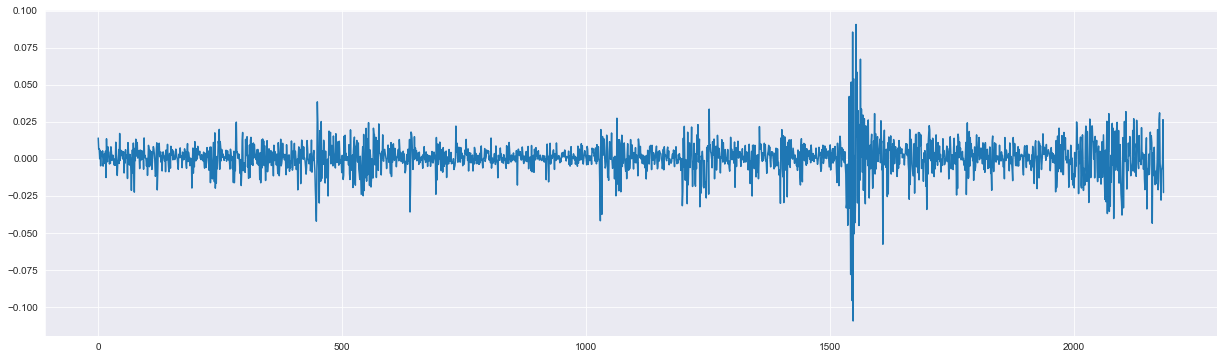

In [41]:
# Visualizamos los retornos
df['next returns'].plot(y='Date',figsize=(21,6))

In [42]:
# Separamos en X - (conjunto de entrenamiento) y Y - (etiquetas de los movimientos)
Y = df['next movement']
X = df
X.drop(['next movement','alpha53'],axis=1,inplace=True)

Tras haber separado las etquetas de los datos y haber eliminado Date y Alpha53, procedemos a separar en Train/Test:

In [22]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,shuffle=False)

fecha_inicio_train = X_train['Date'].iloc[0]
fecha_fin_train = X_train['Date'].iloc[-1]
fecha_inicio_test = X_test['Date'].iloc[0]
fecha_fin_test = X_test['Date'].iloc[-1]

print('Intervalo de entrenamiento:',fecha_inicio_train,'-',fecha_fin_train)
print('Intervalo de prueba:',fecha_inicio_test,'-',fecha_fin_test)

Intervalo de entrenamiento: 2013-10-15 - 2021-01-06
Intervalo de prueba: 2021-01-07 - 2022-10-13


Intervalo de entrenamiento: 2013-10-15 - 2021-01-06
Intervalo de prueba: 2021-01-07 - 2022-10-13

In [23]:
X_train_open = X_train['Open']
X_test_open = X_test['Open']
X_train_close = X_train['Close']
X_test_close = X_test['Close']

Ahora tomamos los retornos, los necesitaremos para calcular el rendimiento de nuestro algoritmo:

In [24]:
X_train_ret = X_train['next returns']
X_test_ret = X_test['next returns']

In [25]:
X_train.drop(['next returns','Date','Open'],axis=1,inplace=True)
X_test.drop(['next returns','Date','Open'],axis=1,inplace=True)

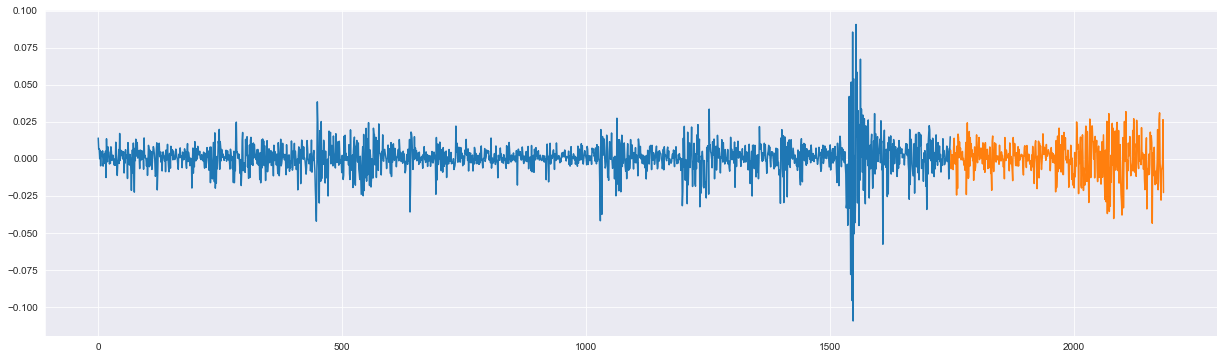

In [26]:
#Plotear Train/Test
plt.figure(figsize=(21,6))
plt.plot(X_train_ret)
plt.plot(X_test_ret)

Añadimos el preprocesado necesario:

In [27]:
X_train.describe()

,Close,alpha1,alpha2,alpha3,alpha4,alpha5,alpha7,alpha8,alpha9,alpha10,alpha11,alpha12,alpha13,alpha14,alpha15,alpha16,alpha17,alpha19,alpha20,alpha21,alpha22,alpha23,alpha24,alpha25,alpha26,alpha27,alpha28,alpha29,alpha30,alpha31,alpha32,alpha33,alpha34,alpha35,alpha36,alpha37,alpha38,alpha39,alpha40,alpha41,alpha42,alpha43,alpha45,alpha46,alpha47,alpha50,alpha51,alpha52,alpha54,alpha55,alpha60,alpha61,alpha62,alpha64,alpha65,alpha66,alpha68,alpha71,alpha72,alpha73,alpha74,alpha75,alpha77,alpha78,alpha81,alpha84,alpha85,alpha86,alpha88,alpha92,alpha94,alpha95,alpha96,alpha98,alpha99,-2 day,-4 day,-6 day,-7 day,-8 day,-9 day,-13 day,-23 day,-27 day
count,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1.747000e+03,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1.747000e+03,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1.747000e+03,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000
mean,226.303104,0.000049,0.095388,0.228628,-0.654137,-0.248861,-0.554503,-0.496759,-0.136334,0.496514,0.749826,0.531792,-0.497357,0.107045,0.182717,-0.507163,-0.128763,-0.463239,-2.000993e-01,-0.268460,-0.007915,-0.613203,-12.177157,0.498198,-0.174223,-0.010876,0.000351,0.624413,0.127138,2.003551,0.009032,0.504767,0.501004,0.122933,2.608607,1.016449,-0.284279,-0.745150,0.092238,-0.079921,1.464999,0.336867,0.041323,0.181297,-0.229759,-0.726387,0.279171,-0.031917,-5.561052e-01,0.315059,-0.000390,0.532341,-0.515741,-0.510590,-0.434459,-1.083612,0.500764,0.608422,2.006829,-0.738547,-0.487121,0.504865,0.678263,0.685452,-0.498569,3.785259e+65,0.699773,-0.502576,0.400785,0.312820,-0.611002,0.546651,0.688026,0.002416,-0.333911,0.000563,0.000583,0.000480,0.000468,0.000482,0.000518,0.000596,0.000581,0.000572
std,53.555905,0.276679,0.451507,0.384418,0.326093,0.135071,0.670466,0.274108,2.716778,0.274474,0.144853,2.667680,0.296159,0.236469,1.456157,0.298119,0.149812,1.413882,2.369383e-01,0.963567,0.383881,1.914548,21.194889,0.274515,0.466333,1.000227,0.000322,0.279535,0.081318,0.413333,0.000739,0.279502,0.284520,0.212365,0.714619,0.390698,0.234634,0.427792,0.239960,1.157470,0.972335,0.295351,0.289533,1.046972,0.455660,0.226542,1.670093,2.127659,2.941470e-01,0.462796,0.000465,0.499096,0.499895,0.500031,0.495828,0.460635,0.275512,0.297997,5.262346,0.204172,0.499977,0.500119,0.231466,0.276175,0.500141,1.582130e+67,0.258647,0.500137,0.249135,0.281730,0.250678,0.497961,0.234087,0.446876,0.238194,0.010977,0.011024,0.011037,0.011047,0.011055,0.011059,0.011055,0.011031,0.011051
min,143.668381,-0.443642,-0.978837,-0.895961,-1.000000,-0.500199,-1.000000,-1.000000,-20.312088,0.000397,0.500398,-28.222412,-1.000000,-0.662731,-2.981334,-1.000000,-0.763374,-1.947949,-9.980134e-01,-1.000000,-1.564461,-20.913203,-108.941498,0.000400,-1.000000,-1.000000,0.000001,0.200002,0.011324,1.027462,0.006737,0.000795,0.000398,0.000000,0.748582,0.002815,-0.855694,-1.836738,-0.672168,-9.168281,0.604707,0.006250,-0.808662,-4.789032,-0.970895,-1.000000,-20.312088,-10.848296,-9.923584e-01,-0.954500,-0.001538,0.000000,-1.000000,-1.000000,-1.000000,-1.985277,0.000397,0.250000,0.003410,-1.000000,-1.000000,0.000000,0.018982,0.006567,-1.000000,1.966951e-07,0.008794,-1.000000,0.000397,0.052632,-0.999734,0.000000,0.125000,-0.971327,-0.994

In [28]:
X_test

,Close,alpha1,alpha2,alpha3,alpha4,alpha5,alpha7,alpha8,alpha9,alpha10,alpha11,alpha12,alpha13,alpha14,alpha15,alpha16,alpha17,alpha19,alpha20,alpha21,alpha22,alpha23,alpha24,alpha25,alpha26,alpha27,alpha28,alpha29,alpha30,alpha31,alpha32,alpha33,alpha34,alpha35,alpha36,alpha37,alpha38,alpha39,alpha40,alpha41,alpha42,alpha43,alpha45,alpha46,alpha47,alpha50,alpha51,alpha52,alpha54,alpha55,alpha60,alpha61,alpha62,alpha64,alpha65,alpha66,alpha68,alpha71,alpha72,alpha73,alpha74,alpha75,alpha77,alpha78,alpha81,alpha84,alpha85,alpha86,alpha88,alpha92,alpha94,alpha95,alpha96,alpha98,alpha99,-2 day,-4 day,-6 day,-7 day,-8 day,-9 day,-13 day,-23 day,-27 day
1747,369.831207,0.302447,0.773566,-0.260968,-1.000000,-0.444156,-0.616667,-0.880895,-5.414337,0.037361,0.565459,5.414337,-0.383207,-0.338431,-1.860176,-0.547553,-0.082443,-1.828849,-3.724904e-01,-1,0.390931,-7.219130,-10.057922,0.056045,-0.968246,-1,0.000241,1.000829,0.024593,1.183813,0.009973,0.105681,0.206210,0.001343,3.330867,1.046338,-0.768963,-1.269505,-0.501402,-1.170927,0.600955,0.06250,0.630628,-1.0,-0.823043,-0.964584,-5.414337,0.783930,-0.768364,0.268147,-0.000370,0,-1,-1,-1,-1.661759,0.980525,0.25,0.751304,-0.811306,-1,0,0.677302,0.507293,-1,0.415126,0.832570,0,0.446563,0.578947,-0.865523,0,0.125000,0.160517,-0.196627,0.005979,-0.013614,0.001427,-0.001908,0.008591,0.003890,-0.003993,0.008618,-0.004427
1748,371.938354,0.302447,0.478898,-0.160313,-1.000000,-0.479656,-0.750000,-0.888489,-2.107147,0.876789,0.792877,-2.107147,-0.272583,-0.112804,-0.031553,-0.315559,-0.051472,-1.823114,-7.180484e-01,-1,0.735234,-4.399681,-9.687256,0.237390,-0.862582,-1,0.000352,0.600847,0.024246,1.154684,0.010097,0.401271,0.276274,0.000000,3.206994,1.256115,-0.514919,-1.404192,-0.433824,-1.923164,0.599238,0.07500,-0.526109,-1.0,-0.882048,-0.695981,-2.107147,1.194613,-0.939315,0.568666,-0.000599,0,0,-1,-1,-1.784322,0.825914,0.25,0.627551,-0.885350,-1,1,0.510501,0.689724,-1,0.401495,0.913932,0,0.471196,0.421053,-0.966715,0,0.125000,0.241559,-0.380090,0.014858,0.006887,0.005081,0.001427,-0.001908,0.008591,-0.003576,-0.002055,0.010937
1749,369.431213,0.002006,0.571287,0.123307,-1.000000,-0.428400,-1.000000,-0.930855,2.507141,0.894674,0.536013,-2.507141,-0.450060,0.009937,0.780726,-0.296458,-0.004677,-1.805911,-1.665895e-03,-1,0.836154,-0.663353,-5.014343,0.851882,-0.342997,1,0.000447,0.401022,0.098196,1.195188,0.009562,0.364720,0.697850,0.063721,3.416381,1.193388,-0.349141,-1.357686,-0.137483,0.446114,0.601529,0.07500,-0.395474,-1.0,-0.853722,-0.695981,2.507141,-0.490424,-0.335418,0.493764,-0.000004,0,-1,-1,-1,-1.943494,0.204293,0.25,0.438831,-0.935908,-1,1,0.382876,0.724330,-1,0.000090,0.964397,0,0.508145,0.263158,-0.948733,0,0.125000,0.292012,-0.283838,0.005698,0.005979,-0.013614,0.005081,0.001427,-0.001908,-0.001685,0.002926,0.002104
1750,369.509247,-0.177497,-0.827823,0.323170,-0.777778,-0.438172,-1.000000,-0.796163,-0.078033,0.483704,0.655989,-0.078033,-0.353760,0.027362,0.024531,-0.237565,-0.143554,-1.797530,-7.401232e-02,-1,1.110489,1.590119,0.321960,0.422338,-0.437237,1,0.000056,1.001022,0.094829,1.734537,0.009473,0.577672,0.648885,0.040466,3.820553,1.366752,-0.232179,-1.313247,0.056371,-0.647818,0.601242,0.18750,-0.383148,1.0,-0.839112,-0.695981,1.000000,-1.280007,-0.689664,0.164742,-0.000406,0,0,-1,-1,-1.807799,0.273052,0.25,0.333033,-0.946656,-1,0,0.619952,0.532830,-1,0.002134,0.961546,0,0.556218,0.210526,-0.911048,0,0.750000,0.315200,-0.444268,-0.006741,0.014858,0.006887,-0.013614,0.005081,0.001427,0.000899,-0.008969,-0.000273
1751,370.504303,-0.320899,-0.865147,0.430441,-1.000000,-0.405265,-1.000000,-0.714628,-0.995056,0.271463,0.608237,0.995056,-0.832471,0.145858,-0.081434,-0.641066,-0.047950,-1.779003,-1.004934e-01,-1,0.499947,-0.273131,1.434052,0.152122,-0.437237,1,0.000359,0.200855,0.079337,1.839510,0.009395,0.317441,0.649682,0.011902,2.241665,0.989579,-0.445501,-1.630159,0.211664,-0.427289,0.600668,0.01875,0.437720,1.0,-0.823044,-0.936729,-0.995056,-1.749451,-0.635244,0.248100,-0.

In [29]:
cols_to_norm = ['Close','alpha54','alpha84']
scaler  = StandardScaler()

X_train[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])
X_test[cols_to_norm] = scaler.transform(X_test[cols_to_norm])

In [30]:
X_train

,Close,alpha1,alpha2,alpha3,alpha4,alpha5,alpha7,alpha8,alpha9,alpha10,alpha11,alpha12,alpha13,alpha14,alpha15,alpha16,alpha17,alpha19,alpha20,alpha21,alpha22,alpha23,alpha24,alpha25,alpha26,alpha27,alpha28,alpha29,alpha30,alpha31,alpha32,alpha33,alpha34,alpha35,alpha36,alpha37,alpha38,alpha39,alpha40,alpha41,alpha42,alpha43,alpha45,alpha46,alpha47,alpha50,alpha51,alpha52,alpha54,alpha55,alpha60,alpha61,alpha62,alpha64,alpha65,alpha66,alpha68,alpha71,alpha72,alpha73,alpha74,alpha75,alpha77,alpha78,alpha81,alpha84,alpha85,alpha86,alpha88,alpha92,alpha94,alpha95,alpha96,alpha98,alpha99,-2 day,-4 day,-6 day,-7 day,-8 day,-9 day,-13 day,-23 day,-27 day
0,-1.543404,0.002006,0.837104,0.144324,-1.000000,-0.334463,-0.250000,-0.772182,1.049805,0.774245,0.568046,1.049805,-0.292479,0.005110,0.749205,-0.211699,-0.066334,-1.704455,-0.078822,1,0.004418,-0.702688,-0.448685,0.810649,-0.153093,1,0.000517,0.800501,0.101570,2.262618,0.009576,0.815256,0.787420,0.088867,4.084379,1.611249,-0.101687,-0.694610,0.120669,0.514674,5.224066,0.24375,0.004800,1.049805,-0.025935,-0.632710,1.049805,0.361050,1.414337,0.810282,0.000439,1,0,-1,0,-1.518504,0.310413,0.750000,0.885964,-0.562500,-1,1,0.616210,0.879408,0,-0.023932,0.854488,0,0.158125,0.052632,-0.456903,0,0.538462,0.085310,-0.445462,0.003994,0.021558,-0.011647,-0.008645,0.007577,-0.009221,-0.004597,0.002249,0.009576
1,-1.505929,0.302447,0.630211,0.005426,-1.000000,-0.330275,-0.916667,-0.832934,-2.006439,0.157393,0.962196,-2.006439,-0.542380,0.069574,-0.770089,-0.475925,-0.514823,-1.715924,-0.227887,1,-0.042422,-0.914302,-1.532364,0.291033,-0.000000,1,0.000058,1.000684,0.102172,2.056087,0.009796,0.106873,0.075637,0.000000,4.076498,1.133670,-0.767939,-0.940392,0.085757,-0.568655,5.015936,0.08750,-0.023507,-1.000000,-0.769765,-0.632710,-2.006439,-1.573277,-1.184630,0.611308,-0.000866,1,0,0,0,-1.581377,0.813196,0.500000,1.106423,-0.729299,-1,1,0.721325,0.845079,0,-0.023932,0.948722,0,0.177195,0.052632,-0.614326,0,0.538462,0.183309,-0.630971,-0.007254,0.006443,0.000725,-0.011647,-0.008645,0.007577,-0.005328,0.005788,0.007397
2,-1.487744,0.302447,0.546596,0.036931,-1.000000,-0.335261,-1.000000,-0.823341,-0.973602,0.275437,0.856745,0.973602,-0.702746,0.099128,-0.741764,-0.722642,-0.138853,-1.726511,-0.033507,-1,-0.144095,-1.837136,-1.930237,0.367094,-0.000000,1,0.000206,0.400684,0.093474,1.945734,0.009799,0.055224,0.362261,0.000000,3.032715,0.938507,-0.812329,-1.126586,0.108477,-0.755883,4.976285,0.05625,0.057800,-1.000000,-0.678034,-0.674095,-0.973602,-1.887008,-1.168986,0.647500,-0.000835,1,0,0,0,-1.627935,0.672099,0.404367,1.338389,-0.766322,0,1,0.803716,0.914001,-1,-0.023932,0.948478,0,0.184346,0.052632,-0.681963,0,0.625000,0.310571,-0.653264,0.013966,0.003994,0.021558,0.000725,-0.011647,-0.008645,0.007916,0.004462,0.003139
3,-1.469244,0.302447,0.609252,0.106372,-1.000000,-0.424411,-1.000000,-0.758993,-0.990524,0.272655,0.652606,-0.990524,-0.685635,0.203446,0.892580,-0.623160,-0.223328,-1.760918,-0.436326,-1,-0.113562,-1.989524,-3.970566,0.343074,-0.000000,-1,0.000190,0.200491,0.020922,1.727205,0.009783,0.308304,0.749602,0.000000,2.966556,1.061145,-0.594820,-1.217416,0.165076,-0.322321,4.956693,0.07500,-0.058314,-1.000000,-0.659047,-0.674095,-0.990524,-1.977283,-1.056265,0.423592,-0.000809,1,0,0,0,-1.685237,0.798092,0.377454,1.454617,-0.789809,0,1,0.834006,0.829326,0,-0.023932,0.955688,0,0.201828,0.052632,-0.731844,0,0.625000,0.461009,-0.732209,0.006683,-0.007254,0.006443,0.021558,0.000725,-0.011647,-0.000945,0.011574,-0.002656
4,-1.469085,0.302447,0.414525,0.514069,-1.000000,-0.420821,-1.000000,-0.754596,-0.008499,0.507552,0.535615,0.008499,-0.590131,0.060679,2.537000,-0.490649,-0.031028,-1.820468,-0.135450,-1,0.051169,-1.210674,-1.972626,0.528423,-0.000000,-1,0.000264,0.400491,0.020686,1.810923,0.009680,0.574891,0.687500,0.021973,3.364707,1.247964,-0.365702,-1.149999,0.375797,-0.017262,4.937255,0.03750,0.059341,-1.000000,-0.519514,-0.674095,-0.008499,-0.690606,0.096330,0.283866,-0.000020,1,0,-1,0,-1.7

Entrenamiento

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejores parametros:( accuracy ) Regresión Logística {'alpha': 0.001, 'eta0': 0.001, 'loss': 'log', 'max_iter': 100, 'penalty': 'l2', 'shuffle': False}
Mejores parametros:( accuracy ) SVM {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Mejores parametros:( accuracy ) RandomForest {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 150, 'random_state': 42}
Mejores parametros:( accuracy ) XGBoost {'reg_alpha': 1, 'random_state': 42, 'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.001, 'gamma': 20}
Win rate: (Regresión Logística) 0.5
Win rate: (SVM) 0.5136986301369864
Win rate: (RandomForest) 0.5205479452054794
Win rate: (XGBoost) 0.5136986301369864


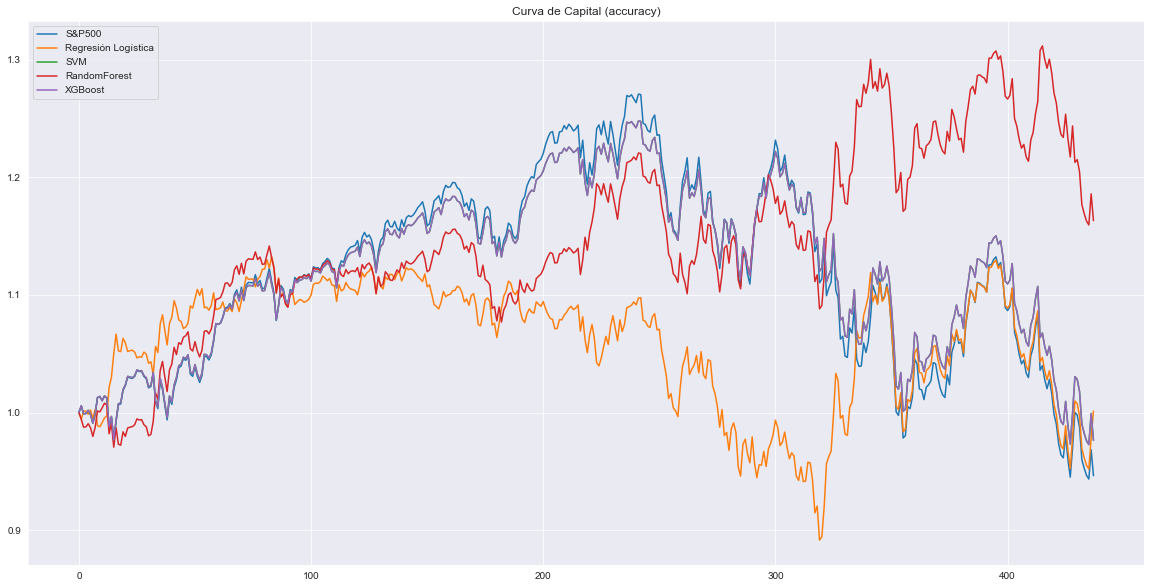

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejores parametros:( roc_auc ) Regresión Logística {'alpha': 0.001, 'eta0': 0.001, 'loss': 'log', 'max_iter': 500, 'penalty': 'l2', 'shuffle': False}
Mejores parametros:( roc_auc ) SVM {'C': 10, 'gamma': 0.01, 'kernel': 'linear'}
Mejores parametros:( roc_auc ) RandomForest {'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 100, 'random_state': 42}
Mejores parametros:( roc_auc ) XGBoost {'reg_alpha': 0.01, 'random_state': 42, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 10}
Win rate: (Regresión Logística) 0.4931506849315068
Win rate: (SVM) 0.5228310502283106
Win rate: (RandomForest) 0.5159817351598174
Win rate: (XGBoost) 0.5273972602739726


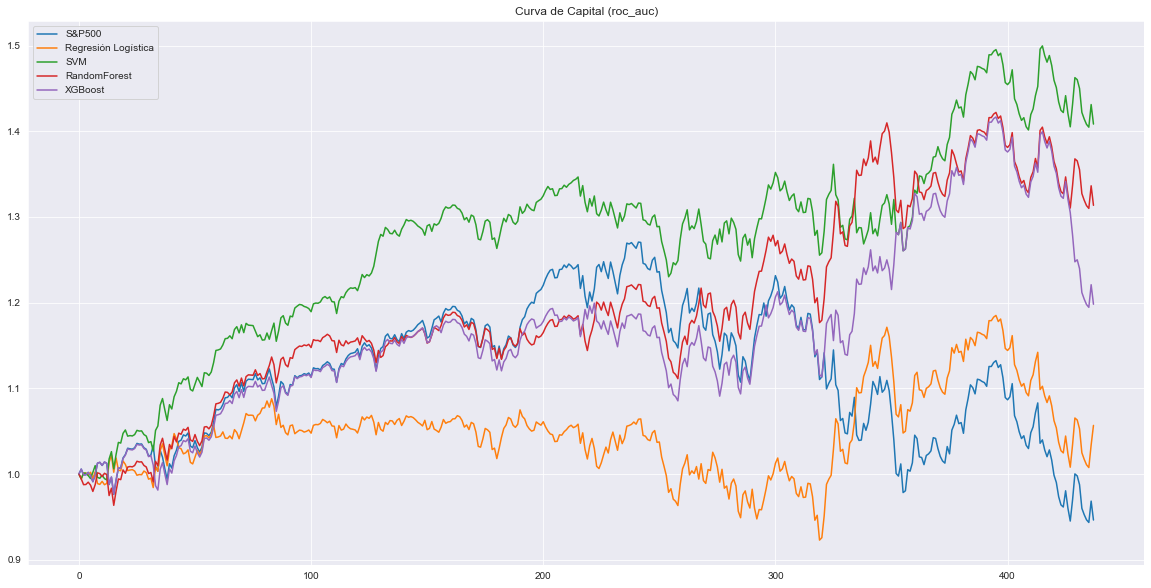

In [14]:
list_estimators = [SGDClassifier(),SVC(),RandomForestClassifier(),xgb.XGBClassifier()]
list_names = ['Regresión Logística','SVM','RandomForest','XGBoost']
metricas = ['accuracy','roc_auc']
primero=True


param_logreg = {
    'loss' : ['log'],
    'penalty' : ['l1','l2'],
    'eta0' : [0.001,0.01,0.1,0.5,1],
    'max_iter' :[100,500,1000,10000],
    'alpha' : [0.001,0.01],
    'shuffle': [False]
}

#Gamma para todos menos lineal, degree solo para poly, C todos
param_svm = {
    'C' : [0.1,1,10],
    'kernel': ['linear','rbf','poly','sigmoid'],
    'gamma' :[0.01,0.1,1,1000]
}


param_rf = {
    'n_estimators':[100,150,200,250,300],
    'max_depth' : [3,4,5,6,7,8],
    'criterion' : ['gini','entropy'],
    'random_state': [42]
}


param_xgb = {
    'max_depth' : [3,4,5,6,7,8],
    'learning_rate' : [0.001,0.01,0.05,0.1],
    'n_estimators' : [100,150,200,250,300,400],
    'gamma' : [0,1,5,10,20,30],
    'reg_alpha' : [0.001,0.01,0.1,1],
    'random_state': [42]
}

list_params = [param_logreg,param_svm,param_rf,param_xgb]
cv = TimeSeriesSplit(5)

for metrica in metricas:
    primero = True
    list_estimators_entrenados = []
    for estimator,param in zip(list_estimators,list_params):
        if not isinstance(estimator,xgb.XGBClassifier):
            busqueda = GridSearchCV(estimator=estimator,param_grid=param,verbose=1,scoring=metrica,refit=True)
        else:
            busqueda = RandomizedSearchCV(estimator=estimator,param_distributions=param,verbose=1,scoring=metrica,refit=True)
        busqueda.fit(X_train,Y_train)
        list_estimators_entrenados.append(busqueda)

    for estimator,name in zip(list_estimators_entrenados,list_names):
        print('Mejores parametros:(',metrica,')',name,estimator.best_params_)
        Y_pred = estimator.predict(X_train)
        mat = ConfusionMatrixDisplay.from_predictions(Y_train,Y_pred)
        plt.grid(False)
        mat.figure_.savefig('{}_Confusion_Mat_{}_Train.jpg'.format(name,metrica))
        plt.close(mat.figure_)
        display = RocCurveDisplay.from_predictions(Y_train,Y_pred)
        display.figure_.savefig('{}_ROC_Curve_{}_Train.jpg'.format(name,metrica))
        plt.close(display.figure_)
        Y_pred = estimator.predict(X_test)
        mat = ConfusionMatrixDisplay.from_predictions(Y_test,Y_pred)
        plt.grid(False)
        mat.figure_.savefig('{}_Confusion_Mat_{}_Test.jpg'.format(name,metrica))
        plt.close(mat.figure_)
        display = RocCurveDisplay.from_predictions(Y_test,Y_pred)
        display.figure_.savefig('{}_ROC_Curve_{}_Test.jpg'.format(name,metrica))
        plt.close(display.figure_)

    plt.figure(figsize=(20,10))
    for estimator,name in zip(list_estimators_entrenados,list_names):
        Y_pred = estimator.predict(X_test)
        if primero:
            mercado=1
            primero=False
        else:
            mercado=0
        backtest_1day_hold(X_test_ret,Y_pred,show_market=mercado,label=name)
    plt.title('Curva de Capital ({})'.format(metrica))
    plt.legend()
    plt.show()

Day  1 Going Short : Amount betted: 1 Daily return: 0.0056975916995229  End amount: 0.9943024083004771 Equity change: -0.005697591699522886 Equity: 0.9943024083004771
Day  2 Going Short : Amount betted: 1 Daily return: -0.0067407436823886  End amount: 1.0067407436823885 Equity change: 0.006740743682388528 Equity: 1.0010431519828655
Day  3 Going long : Amount betted: 1 Daily return: 0.0002112259182214  End amount: 1.0002112259182214 Equity change: 0.0002112259182214249 Equity: 1.001254377901087
Day  4 Going Short : Amount betted: 1 Daily return: 0.0026929127238102  End amount: 0.9973070872761898 Equity change: -0.0026929127238102257 Equity: 0.9985614651772767
Day  5 Going Short : Amount betted: 1 Daily return: -0.0035019440830562  End amount: 1.0035019440830562 Equity change: 0.003501944083056152 Equity: 1.0020634092603329
Day  6 Going long : Amount betted: 1 Daily return: -0.0072927564493436  End amount: 0.9927072435506564 Equity change: -0.007292756449343574 Equity: 0.9947706528109893

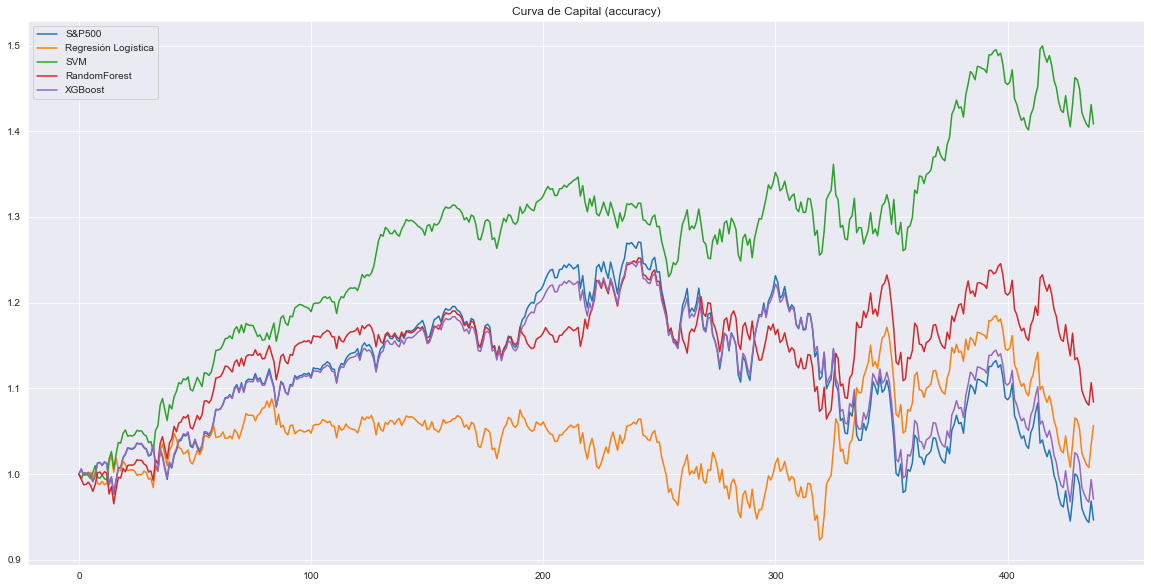

Day  1 Going Short : Amount betted: 1 Daily return: 0.0056975916995229  End amount: 0.9943024083004771 Equity change: -0.005697591699522886 Equity: 0.9943024083004771
Day  2 Going Short : Amount betted: 1 Daily return: -0.0067407436823886  End amount: 1.0067407436823885 Equity change: 0.006740743682388528 Equity: 1.0010431519828655
Day  3 Going long : Amount betted: 1 Daily return: 0.0002112259182214  End amount: 1.0002112259182214 Equity change: 0.0002112259182214249 Equity: 1.001254377901087
Day  4 Going Short : Amount betted: 1 Daily return: 0.0026929127238102  End amount: 0.9973070872761898 Equity change: -0.0026929127238102257 Equity: 0.9985614651772767
Day  5 Going Short : Amount betted: 1 Daily return: -0.0035019440830562  End amount: 1.0035019440830562 Equity change: 0.003501944083056152 Equity: 1.0020634092603329
Day  6 Going long : Amount betted: 1 Daily return: -0.0072927564493436  End amount: 0.9927072435506564 Equity change: -0.007292756449343574 Equity: 0.9947706528109893

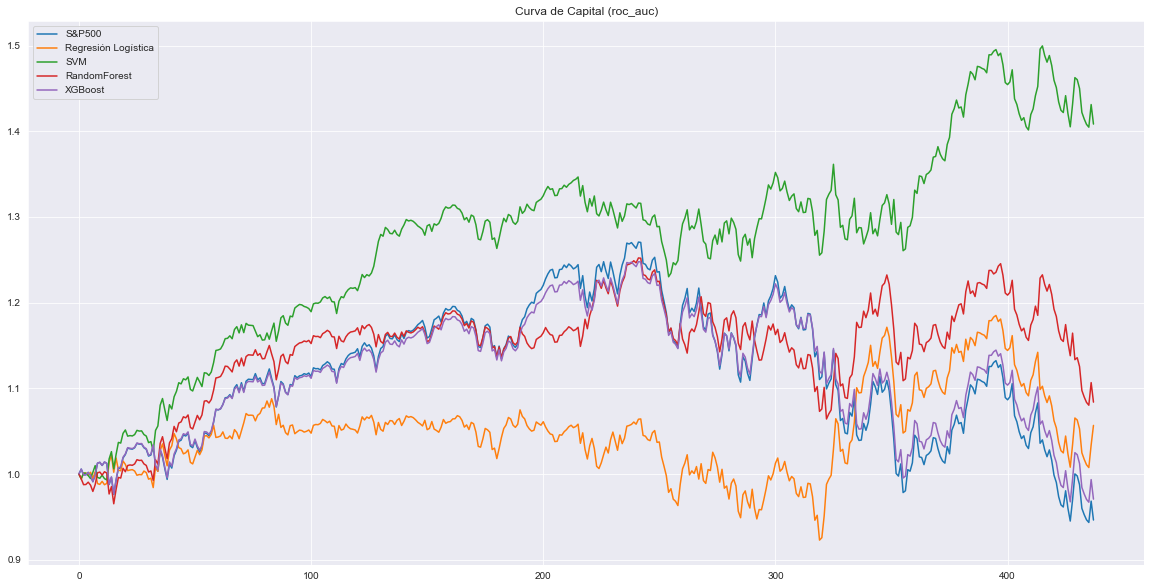

In [33]:
###############################################################################
####################################PRUEBA#####################################
###############################################################################
list_estimators = [SGDClassifier(),SVC(),RandomForestClassifier(),xgb.XGBClassifier()]
list_names = ['Regresión Logística','SVM','RandomForest','XGBoost']
metricas = ['accuracy','roc_auc']
primero=True

#   Mejores parametros:( accuracy ) Regresión Logística {'alpha': 0.001, 'eta0': 0.001, 'loss': 'log', 'max_iter': 100, 'penalty': 'l2', 'shuffle': False}
# Mejores parametros:( roc_auc ) Regresión Logística {'alpha': 0.001, 'eta0': 0.001, 'loss': 'log', 'max_iter': 500, 'penalty': 'l2', 'shuffle': False}
param_logreg = {
    'loss' : ['log'],
    'penalty' : ['l1','l2'],
    'eta0' : [0.01],
    'max_iter' :[1000],
    'alpha' : [0.01,0.001],
    'shuffle': [False]
}

#Mejores parametros:( accuracy ) SVM {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
#Mejores parametros:( roc_auc ) SVM {'C': 10, 'gamma': 0.01, 'kernel': 'linear'}
param_svm = {
    'C' : [0.1,10],
    'kernel': ['linear','rbf'],
    'gamma' :[0.1]
}

# Mejores parametros:( accuracy ) RandomForest {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 150, 'random_state': 42}
#Mejores parametros:( roc_auc ) RandomForest {'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 100, 'random_state': 42}
param_rf = {
    'n_estimators':[100,250],
    'max_depth' : [4,7],
    'criterion' : ['gini'],
    'random_state': [42]
}

# Mejores parametros:( accuracy ) XGBoost {'reg_alpha': 1, 'random_state': 42, 'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.001, 'gamma': 20}
# Mejores parametros:( roc_auc ) {'reg_alpha': 0.01, 'random_state': 42, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 10}
param_xgb = {
    'max_depth' : [3],
    'learning_rate' : [0.01],
    'n_estimators' : [200,300],
    'gamma' : [10],
    'reg_alpha' : [0.01],
    'random_state': [42]
}

list_params = [param_logreg,param_svm,param_rf,param_xgb]
cv = TimeSeriesSplit(5)
list_estimators_entrenados_accuracy=[]
list_estimators_entrenados_roc_auc=[]

for metrica in metricas:
    primero = True

    for estimator,param in zip(list_estimators,list_params):
        if not isinstance(estimator,xgb.XGBClassifier):
            busqueda = GridSearchCV(estimator=estimator,param_grid=param,verbose=0,scoring=metrica,refit=True)
        else:
            busqueda = RandomizedSearchCV(estimator=estimator,param_distributions=param,verbose=0,scoring=metrica,refit=True)
        busqueda.fit(X_train,Y_train)
        list_estimators_entrenados.append(busqueda)

    plt.figure(figsize=(20,10))
    for estimator,name in zip(list_estimators_entrenados,list_names):
        Y_pred = estimator.predict(X_test)
        if primero:
            mercado=1
            primero=False
        else:
            mercado=0
        backtest_1day_hold(X_test_ret,Y_pred,show_market=mercado,verbose=0,label=name)
    plt.title('Curva de Capital ({})'.format(metrica))
    plt.legend()
    plt.show()

Win rate: (Regresión Logística) 0.5296803652968036
Win rate: (SVM) 0.5296803652968036
Win rate: (RandomForest) 0.5296803652968036
Win rate: (XGBoost) 0.5319634703196348


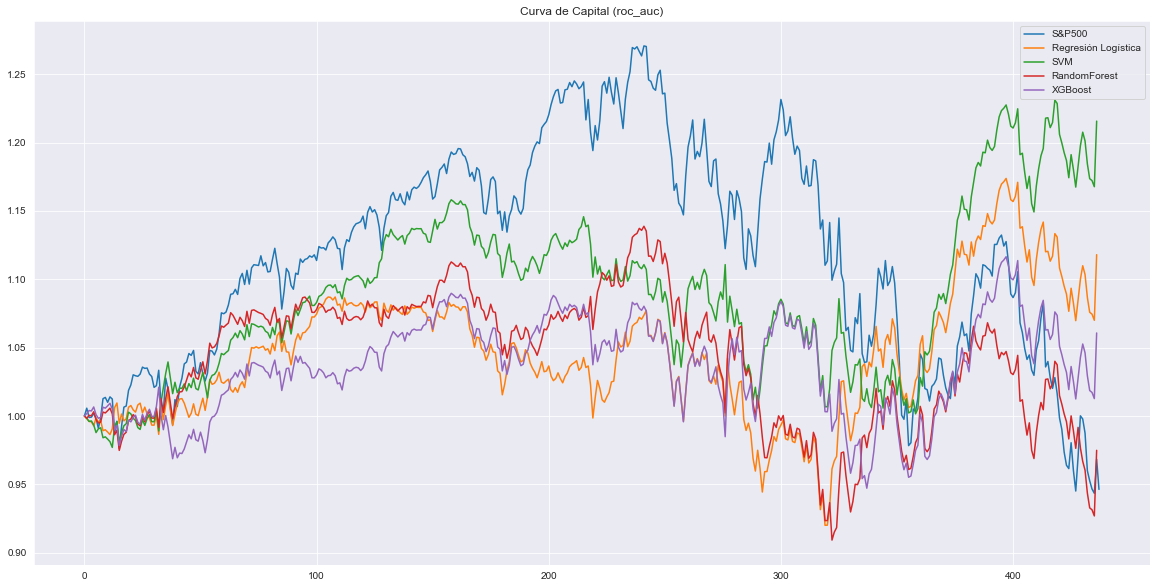

In [34]:
primero = True

plt.figure(figsize=(20,10))
for estimator,name in zip(list_estimators_entrenados,list_names):
    Y_pred = estimator.predict(X_test)
    if primero:
        mercado=1
        primero=False
    else:
        mercado=0
    backtest_1day_hold_open(X_test_open,X_test_close,X_test_ret,Y_pred,verbose=0,show_market=mercado,label=name)
plt.title('Curva de Capital ({})'.format(metrica))
plt.legend()
plt.show()

In [62]:
from sklearn.tree import export_graphviz

export_graphviz(list_estimators_entrenados[2].best_estimator_.estimators_[6], out_file='tree.dot',
                feature_names = X_train.columns,
                class_names = ['up','down'],
                rounded = True, proportion = False,
                precision = 2, filled = True)

list_estimators_entrenados[2].best_estimator_.estimators_[6]

In [65]:
import os
os.system('dot -Tpng tree.dot -o tree.png')

1

[Text(0.49107142857142855, 0.9, 'alpha25 <= 0.599\ngini = 0.493\nsamples = 1090\nvalue = [773, 974]'),
 Text(0.26785714285714285, 0.7, 'alpha43 <= 0.631\ngini = 0.5\nsamples = 680\nvalue = [524, 556]'),
 Text(0.14285714285714285, 0.5, '-4 day <= -0.003\ngini = 0.5\nsamples = 613\nvalue = [494, 477]'),
 Text(0.07142857142857142, 0.3, 'alpha9 <= -2.478\ngini = 0.477\nsamples = 139\nvalue = [86, 133]'),
 Text(0.03571428571428571, 0.1, '\n  (...)  \n'),
 Text(0.10714285714285714, 0.1, '\n  (...)  \n'),
 Text(0.21428571428571427, 0.3, 'alpha60 <= -0.0\ngini = 0.496\nsamples = 474\nvalue = [408, 344]'),
 Text(0.17857142857142858, 0.1, '\n  (...)  \n'),
 Text(0.25, 0.1, '\n  (...)  \n'),
 Text(0.39285714285714285, 0.5, 'alpha68 <= 0.947\ngini = 0.399\nsamples = 67\nvalue = [30, 79]'),
 Text(0.35714285714285715, 0.3, 'alpha50 <= -0.54\ngini = 0.357\nsamples = 64\nvalue = [24, 79]'),
 Text(0.32142857142857145, 0.1, '\n  (...)  \n'),
 Text(0.39285714285714285, 0.1, '\n  (...)  \n'),
 Text(0.4285

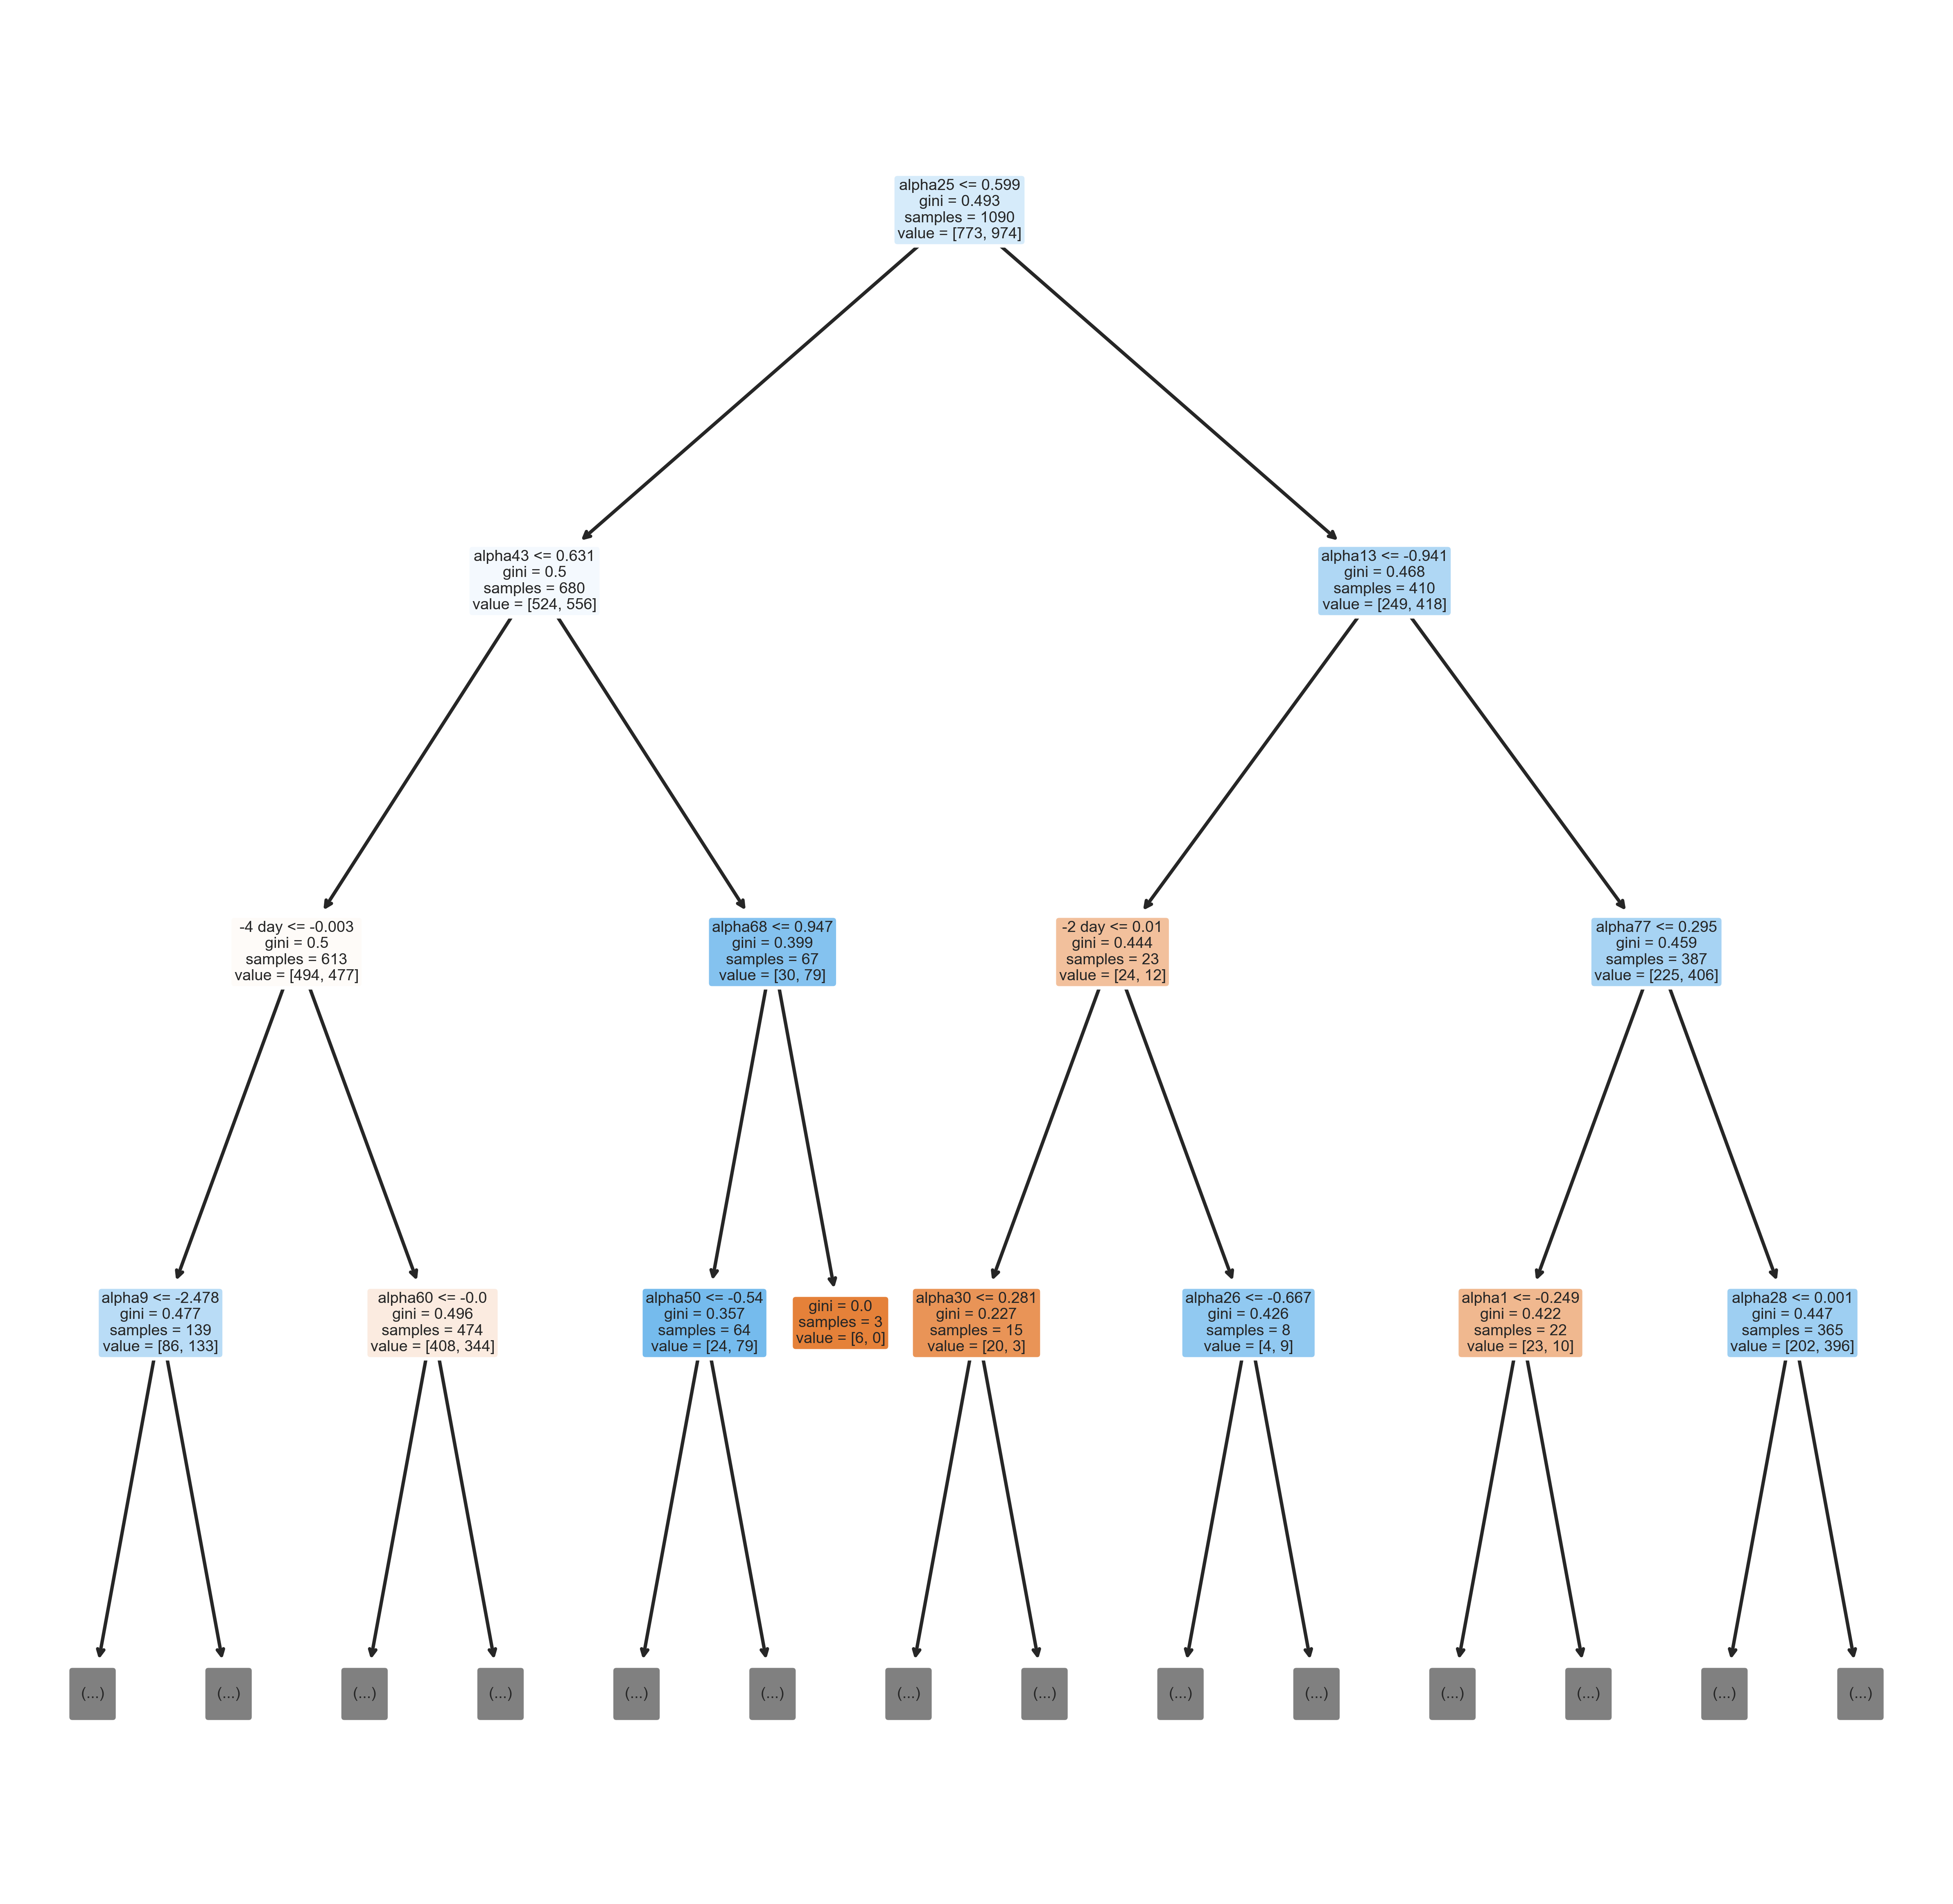

In [71]:
from sklearn.tree import plot_tree
plt.figure(figsize=(10,10),dpi=600)
plot_tree(list_estimators_entrenados[2].best_estimator_.estimators_[6],feature_names=X_train.columns ,max_depth=3,filled=True,rounded=True)